In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import exp, log
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
import sys
sys.path.append('..')
%matplotlib inline

## Back from the theory: the BP-Algorithm
- first, something to play with: https://playground.tensorflow.org/

## BP on Loss-Function
 - usually, the crosse-entropy error-function is used in a multi-classification problem
 - adapted: $H(p,q) = - \sum_x p(x) \mathrm{log}  q(x) + (1 - p(x)) \mathrm{log}  (1 - q(x)) $

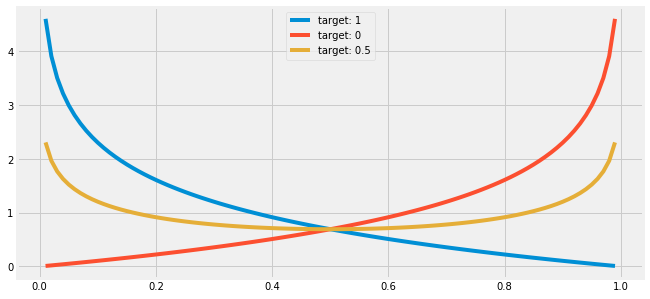

In [4]:
def cross_entropy(x, y):
    probs = x * np.log(y) + (1-x) * np.log((1-y))
    return (-1)*np.sum(probs.reshape((99,1)), axis=1)

data = np.arange(0.01, 1, 0.01)
res_1 = cross_entropy(np.repeat(1, 99), data)
res_2 = cross_entropy(np.repeat(0.5, 99), data)
res_3 = cross_entropy(np.repeat(0, 99), data)
plt.figure(figsize=(10,5))
fig = plt.plot(data, res_1, label="target: 1")
fig = plt.plot(data, res_3, label="target: 0")
fig = plt.plot(data, res_2, label="target: 0.5")
plt.legend()
plt.show()

 - why? focusing on the stuff you've got wrong proved to be sucessfull (overfitting etc.)
 - still accetable learning rate if near optimum
 in NNs usually: $H(target, output)$

#### derivation of cross-entropy error function
### $\frac{\partial H}{\partial o_i} = \frac{-t_i}{o_i} + \frac{1-t_i}{1-o_i} = \frac{o_i-t_i}{o_i(1-o_i)}$

In [5]:
def cross_entropy_deriv(x, y):
    return (x - y)/(x*(1-x))

## BP through Activation Functions
sigmoid is defined as:
#### $f(x)=\frac{1}{1+e^{-x}}$
derivation:
#### $\begin{align}
\frac{d f(x)}{d x} & = [\frac{1}{1+e^{-x}}]' \\
 & = [\frac{e^x}{1+e^{x}}]' \\
 & = \frac{e^x}{(1+e^{x})^2}\\
 & = f(x)(1-f(x))
\end{align}$

In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoidDeriv(x):
    sigm = sigmoid(x)
    return sigm*(1-sigm)

## BP on weights and biases
#### $n=n(x)=w^T \cdot x + b$
#### $\frac{d n}{d w_i} = x_i$

## Putting it together: Breast Cancer Wisconsin (Diagnostic) Dataset
#### definitions: $y = f_{sigmoid}(n)$, $n = w^T \cdot x + b$ and trained with $H_{crossentropy}(target, y)$
#### $\begin{align}
\frac{\partial H}{\partial w_i} & = \frac{\partial H}{\partial y}\frac{\partial y}{\partial w_i} \\
 & = \frac{\partial H}{\partial y}\frac{\partial y}{\partial n}\frac{\partial n}{\partial w_i} \\
 & = \frac{y-t}{y(1-y)}\frac{\partial y}{\partial n}\frac{\partial n}{\partial w_i}\\
 & = \frac{y-t}{y(1-y)}(y \cdot (1-y))\frac{\partial n}{\partial w_i}\\
 & = (y-t)\frac{\partial n}{\partial w_i} \\
 & = (y-t)x_i
\end{align}$
bias is similiar

In [7]:
from src.backward import *
backwardB = BackwardWeightsBCW()

foreward pass: $\mathbb{R}^{n \times 30} \rightarrow \mathbb{R}^n$

In [8]:
def forewardPass(data):
    x = sigmoid(np.dot(data, backwardB.getWeights().transpose()) + backwardB.getBias())
    return x

 - backward pass: $\mathbb{R}^{n \times 30} \rightarrow \bot$
 - use learning rate of `0.005`
 - use `np.mean(a, axis=z)` for computing the mean across an axis
 - use `np.einsum(a, b, axes=1)` for a more generalized dot product 

In [9]:
def backwardPass(train_x, train_y):
    res = forewardPass(train_x)
    temp = res - train_y
    #temp = cross_entropy_deriv(res, train_y)
    #import ipdb; ipdb.set_trace()
    gradient = np.einsum('ij,ik->ijk',temp,train_x).reshape(-1,30)
    gr_mean = np.mean(gradient, axis=0)
    newWeights = backwardB.getWeights() - (0.005) * gr_mean
    backwardB.setWeights(newWeights)
    newBias = backwardB.getBias() - (0.005) * np.mean(temp)
    #print(np.sum(newWeights), newBias)
    backwardB.setBias(newBias)

test whether your implementations is correct. For output $y$ the input is $(y,1,1,1,....,1)$

In [10]:
backwardB.setWeights(np.ones((1,30)))
backwardB.setBias(np.array(1))
train = backwardB.getTrainID(backwardPass, forewardPass, 10)

 BCW-Dataset
 - recommended learning rate: 0.005
 - iterations: 100, print every iterations

In [11]:
#backwardB.solveWeights()
backwardB.resetWeights()
train = backwardB.getTrain(backwardPass, forewardPass)

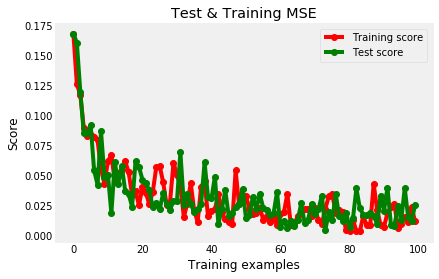

In [12]:
train.train(1000,10)

## Putting it together: MNIST
![alt text](../assets/mlp_model.png)

"from last to the first layer" 

pretty similiar, don't get confused by all the indices!
#### definitions: $y_{iz} = f_{sigmoid}(n_{iz})$, $n_{iz} = w_{iz}^T \cdot x_z + b_{iz}$ and trained with $H_{crossentropy}(\vec{target}, \vec{y_2})$, where $iz$ is the $i$-th result in layer $z$ (output layer has the highest number)
#### $\begin{align}
\frac{\partial H}{\partial w_{piz}} & = \frac{\partial H}{\partial y_{iz}}\frac{\partial y_{iz}}{\partial w_{piz}} \\
 & = \frac{\partial H}{\partial y_{iz}}\frac{\partial y_{iz}}{\partial n_{iz}}\frac{\partial n_{iz}}{\partial w_{piz}} \\
 & = \frac{\partial H}{\partial y_{iz}}\frac{\partial y_{iz}}{\partial n_{iz}}x_{piz} \\
 & = \frac{\partial H}{\partial y_{iz}}y_{iz}(1 - y_{iz})x_{piz}\\
 & =(\sum_{j_{(z +1)} = 0}^{l_{(z+1)}}\frac{\partial H}{\partial y_{j_{(z+1)}(z + 1)}}\frac{\partial y_{j_{(z+1)}(z + 1)}}{\partial y_{iz}})y_{iz}(1 - y_{iz})x_{piz} \\
 & =(\sum_{j_{(z +1)} = 0}^{l_{(z+1)}}\frac{\partial H}{\partial y_{j_{(z+1)}(z + 1)}}\frac{\partial y_{j_{(z+1)}(z + 1)}}{\partial n_{j_{(z+1)}(z + 1)}}\frac{\partial n_{j_{(z+1)}(z + 1)}}{\partial y_{iz}})y_{iz}(1 - y_{iz})x_{piz} \\
 & =(\sum_{j_{(z +1)} = 0}^{l_{(z+1)}}\frac{\partial H}{\partial y_{j_{(z+1)}(z + 1)}}\frac{\partial y_{j_{(z+1)}(z + 1)}}{\partial n_{j_{(z+1)}(z + 1)}}w_{ij_{(z+1)}(z + 1)})y_{iz}(1 - y_{iz})x_{piz} \\
  & =(\sum_{j_{(z +1)} = 0}^{l_{(z+1)}}\text{already computed!}w_{ij_{(z+1)}(z + 1)})y_{iz}(1 - y_{iz})x_{piz} \\
  & =(\sum_{j_{(z +1)} = 0}^{l_{(z+1)}}RESULT_{j_{(z+1)}(z+1)}w_{ij_{(z+1)}(z + 1)})y_{iz}(1 - y_{iz})x_{piz}
\end{align}$
bias is similiar

In [13]:
from src.backward import *
backwardMNIST = BackwardWeightsMNIST()

In [14]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

 - foreward pass: $\mathbb{R}^{n \times 784} \rightarrow \mathbb{R}^{n \times 10}$

In [29]:
def forewardMNIST(data):
    hidden = sigmoid(np.dot(data, backwardMNIST.getWeights(0)) + backwardMNIST.getBias(0))
    out = softmax(np.dot(hidden, backwardMNIST.getWeights(1)) + backwardMNIST.getBias(1))
    return out

def getClass(data):
    proba = forewardMNIST(data)
    return np.argmax(proba, axis=1)

 - backward pass: $\mathbb{R}^{n \times 784} \rightarrow \bot$
 - use learning rate of `0.005`
 - use `np.mean(a, axis=z)` for computing the mean across an axis
 - use `np.einsum(a, b, axes=1)` for a more generalized dot product 

In [30]:
def backwardPassMNIST(train_x, train_y):
    hidden = sigmoid(np.dot(train_x, backwardMNIST.getWeights(0)) + backwardMNIST.getBias(0))
    out = softmax(np.dot(hidden, backwardMNIST.getWeights(1)) + backwardMNIST.getBias(1))
    temp = (out - train_y)
    #print(np.min(temp))
    #import ipdb; ipdb.set_trace()
    gradient_1 = np.einsum('ij,ik->ijk',temp,hidden)
    gradient_1 = np.mean(gradient_1, axis=0)
    newWeights_1 = backwardMNIST.getWeights(1) - (0.05) * gradient_1.transpose()
    backwardMNIST.setWeights(1, newWeights_1)
    newBias_1 = backwardMNIST.getBias(1) - (0.05) * np.mean(temp, axis=0)
    backwardMNIST.setBias(1, newBias_1)
    
    layer1 = np.einsum('ij,ik->ijk',temp,hidden)
    layer1 = np.sum(layer1, axis=1) * (hidden * (1 - hidden))
    gradient_0 = np.einsum('ij,ik->ijk',layer1,train_x)
    gradient_0 = np.mean(gradient_0, axis=0)                      
    backwardMNIST.setWeights(0, backwardMNIST.getWeights(0) - (0.005) * gradient_0.transpose())
    #import ipdb; ipdb.set_trace()
    newBias_0 = backwardMNIST.getBias(0) - (0.005) * np.mean(layer1, axis=0)
    backwardMNIST.setBias(0, newBias_0)

use this cell to train & test with only one layer:

In [23]:
backwardMNIST.setWeights(0,np.ones((784, 50))/784)
backwardMNIST.setWeights(1,np.ones((784, 10))/784)
backwardMNIST.setBias(0,np.zeros((50,)))
backwardMNIST.setBias(1,np.zeros((10,)))
train = backwardMNIST.getTrainID(backwardPassMNIST, forewardMNIST, 1)

use this cell to train & test with both layers

In [31]:
backwardMNIST.setWeights(0,np.ones((784, 50))/784)
backwardMNIST.setWeights(1,np.ones((50, 10))/50)
backwardMNIST.setBias(0,np.zeros((50,)))
backwardMNIST.setBias(1,np.zeros((10,)))
train = backwardMNIST.getTrainID(backwardPassMNIST, forewardMNIST, 1)

the real MNIST

In [81]:
backwardMNIST.resetWeights()
train = backwardMNIST.getTrain(backwardPassMNIST, forewardMNIST)

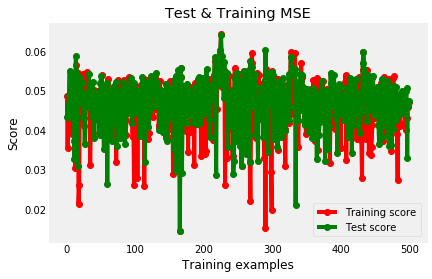

In [33]:
train.train(500,1)

further resources:
 - https://playground.tensorflow.org/
 - https://fosterelli.co/executing-gradient-descent-on-the-earth
 - https://page.mi.fu-berlin.de/rojas/neural/chapter/K7.pdf
 - https://www.ics.uci.edu/~pjsadows/notes.pdf